In [1]:
import spacy
from spacy import displacy
from spacy.util import filter_spans
import re
import pandas as pd
import pickle
nlp = spacy.load('en_core_web_trf')
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from tqdm import tqdm
from spacy.lang.en import English
%matplotlib inline

In [2]:
data = pickle.load(open('../../data/description/03_descriptions_0-500.pkl', 'rb'))

In [3]:
#data['Chusquea tomentosa']

In [4]:
sents = [sent[0] for sent in data['Chusquea tomentosa']]

In [18]:
strings = ['the Brown bears have 4 long claws and 2 short ears.',
           'The Brown bear has a brown fur.',
            'The Brown bear has a black nose.',
            'The Brown bear has a large nose.',
            'The Brown bear has a bold belly.',
            'Their feet are orange.',
            'The Brown bear has similar feet as the black bear.',
            'The claws have 5 sharp nails and are 8.5 cm long.',
            'The belly is bold and grey',
            'The nose is black and shiny',
            'It has dark ears',
            'legs muscular with curved nails'
          ]




In [19]:
doc = nlp(strings[-1])

In [20]:
displacy.render(doc)

In [21]:

def real_subject_object(doc):
    
    
    triples = []
    empty = nlp(' ')[0]
     # Find Root
    root = next(token for token in doc if token.dep_ == 'ROOT')
    if root:
        # Find normal subject + compound if exists
        subject_base = next((child for child in root.children if child.dep_ == 'nsubj'), empty)
        subject_comp = next((child for child in subject_base.children if child.dep_ == 'compound' 
                                                                      if child.pos_ == 'PROPN'), empty)

        # Lemmatize and lower
        subject_base_string = subject_base.lemma_.lower()
        subject_comp_string = subject_comp.lemma_.lower()
        # Concat
        subject_string = f'{subject_comp_string} {subject_base_string}'

        # Find direct object
        object_ = next((child for child in root.children if child.dep_ == 'dobj' 
                                                         if child.pos_ == 'NOUN'), empty)
        
        # Lemmatize and lower
        object_string = object_.lemma_.lower()   
        # Lemmatize root
        root_string = root.lemma_.lower()
        
        # Find conjectures related to object:
        object_cc = [child for child in object_.children if child.dep_ == 'conj']
        #print(object_cc)
        if object_cc:
            for conjectures in object_cc:
                object_cc_string = conjectures.lemma_.lower()
                triples.append((subject_string.strip(), root_string.strip(), object_cc_string.strip()))
    
        triples.append((subject_string.strip(), root_string.strip(), object_string.strip()))
        
        return triples
    
def real_subject_acomp(doc):
    triples = []
    empty = nlp(' ')[0]
     # Find Root
    root = next(token for token in doc if token.dep_ == 'ROOT')
    if root:
        # Find normal subject + compound if exists
        subject_base = next((child for child in root.children if child.dep_ == 'nsubj'), empty)
        subject_comp = next((child for child in subject_base.children if child.dep_ == 'compound' 
                                                                      if child.pos_ == 'PROPN'), empty)

        # Lemmatize and lower
        subject_base_string = subject_base.lemma_.lower()
        subject_comp_string = subject_comp.lemma_.lower()
        # Concat
        subject_string = f'{subject_comp_string} {subject_base_string}'

        # Find direct object
        object_ = next((child for child in root.children if child.dep_ == 'acomp'), empty)
        
        # Lemmatize and lower
        object_string = object_.lemma_.lower()   
        # Lemmatize root
        root_string = root.lemma_.lower()
        
        # Find conjectures related to object:
        object_cc = [child for child in object_.children if child.dep_ == 'conj']
        #print(object_cc)
        if object_cc:
            for conjectures in object_cc:
                object_cc_string = conjectures.lemma_.lower()
                triples.append((subject_string.strip(), root_string.strip(), object_cc_string.strip()))
    
        triples.append((subject_string.strip(), root_string.strip(), object_string.strip()))
        
        return triples    

def direct_object_amod(doc):
    
    triples = []
    empty = nlp(' ')[0]
    # Find direct object
    object_ = next((token for token in doc if token.dep_ == 'dobj' 
                                           if token.pos_ == 'NOUN'), empty)
    # Find amod
    amod = next((child for child in object_.children if child.dep_ == 'amod'), empty)
    amod_string = amod.lemma_.lower()
    
    # Lemmatize and lower
    object_ = object_.lemma_.lower()
    
    if amod.pos_ == 'NOUN':
        triples.append((object_.strip(), 'have', amod_string))
    else:
        triples.append((object_.strip(), 'be', amod_string))
        
    return triples
    
def noun_numbers(doc):
    
    triples = []
    empty = nlp(' ')[0]
    # Find nouns
    nouns = [token for token in doc if token.pos_ == 'NOUN']
    #print(nouns)
    if nouns:
        for noun in nouns:
            children = [child for child in noun.children if child.dep_ == 'nummod']
            for child in children:
                #print(child)
                noun_string = noun.lemma_.strip()
                triples.append((noun_string.lower(), 'number', child.lemma_))
            
    return triples

def measurements(doc):
    triples = []
    empty = nlp(' ')[0]
    # Find adjectives
    adjectives = [token for token in doc if token.pos_ == 'ADJ']
    #print(adjectives)
    if adjectives:
        for adjective in adjectives:
            for child in adjective.children:
                #print(child)
                if child.dep_ == 'npadvmod':
                    adjective_string = adjective.lemma_.lower()
                    child_string = child.lemma_.strip()
                    #print(child_string)
                    triples.append((adjective_string.strip(), 'measurement', child_string.strip()))
                    
    return triples

def possesions(doc):
    triples = []
    
    nouns = [token for token in doc if token.pos_ == 'NOUN']
    for noun in nouns:
        for child in noun.children:
            if child.pos_ == 'PRON':
                noun_string = noun.lemma_.lower()
                triples.append((species.lower(), 'have', noun_string.strip()))
                
    return triples

def noun_root(doc):
    
    triples = []
    
    root = next(token for token in doc if token.dep_ == 'ROOT')
    #print(root.pos_)
    if root.pos_ not in ['VERB', 'AUX']:
        # If root is noun append to species
        if root.pos_ == 'NOUN':
            root_string = root.lemma_.lower()
            triples.append((species.lower(), 'have', root_string.strip()))
            
            # Extract ADJs
            for child in root.children:
                if child.pos_ == 'ADJ':
                    child_string = child.lemma_.lower()
                    triples.append((root_string.strip(), 'be', child_string.lower()))
            
    return triples


In [22]:
triples = []
species = 'Brown bear'

for idx, sent in enumerate(tqdm(strings)):
    doc = nlp(sent)
    
    # Neural coref (BASIC)
    text = ' '.join([species if token.pos_ == 'PRON' else token.text for token in doc])
    doc = nlp(text)
    
    triples.append(real_subject_object(doc))
    triples.append(real_subject_acomp(doc))
    triples.append(direct_object_amod(doc))
    triples.append(noun_numbers(doc))
    triples.append(measurements(doc))
    triples.append(possesions(doc))
    triples.append(noun_root(doc))

100%|███████████████████████████████████████████| 12/12 [00:05<00:00,  2.38it/s]


### VIZ

In [23]:
triples = [RDF for RDF_list in triples for RDF in RDF_list]

source   = []
relation = []
target   = []


for triple in triples:
    if not all(triple):
        continue
    source.append(triple[0])
    relation.append(triple[1])
    target.append(triple[2])
    
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

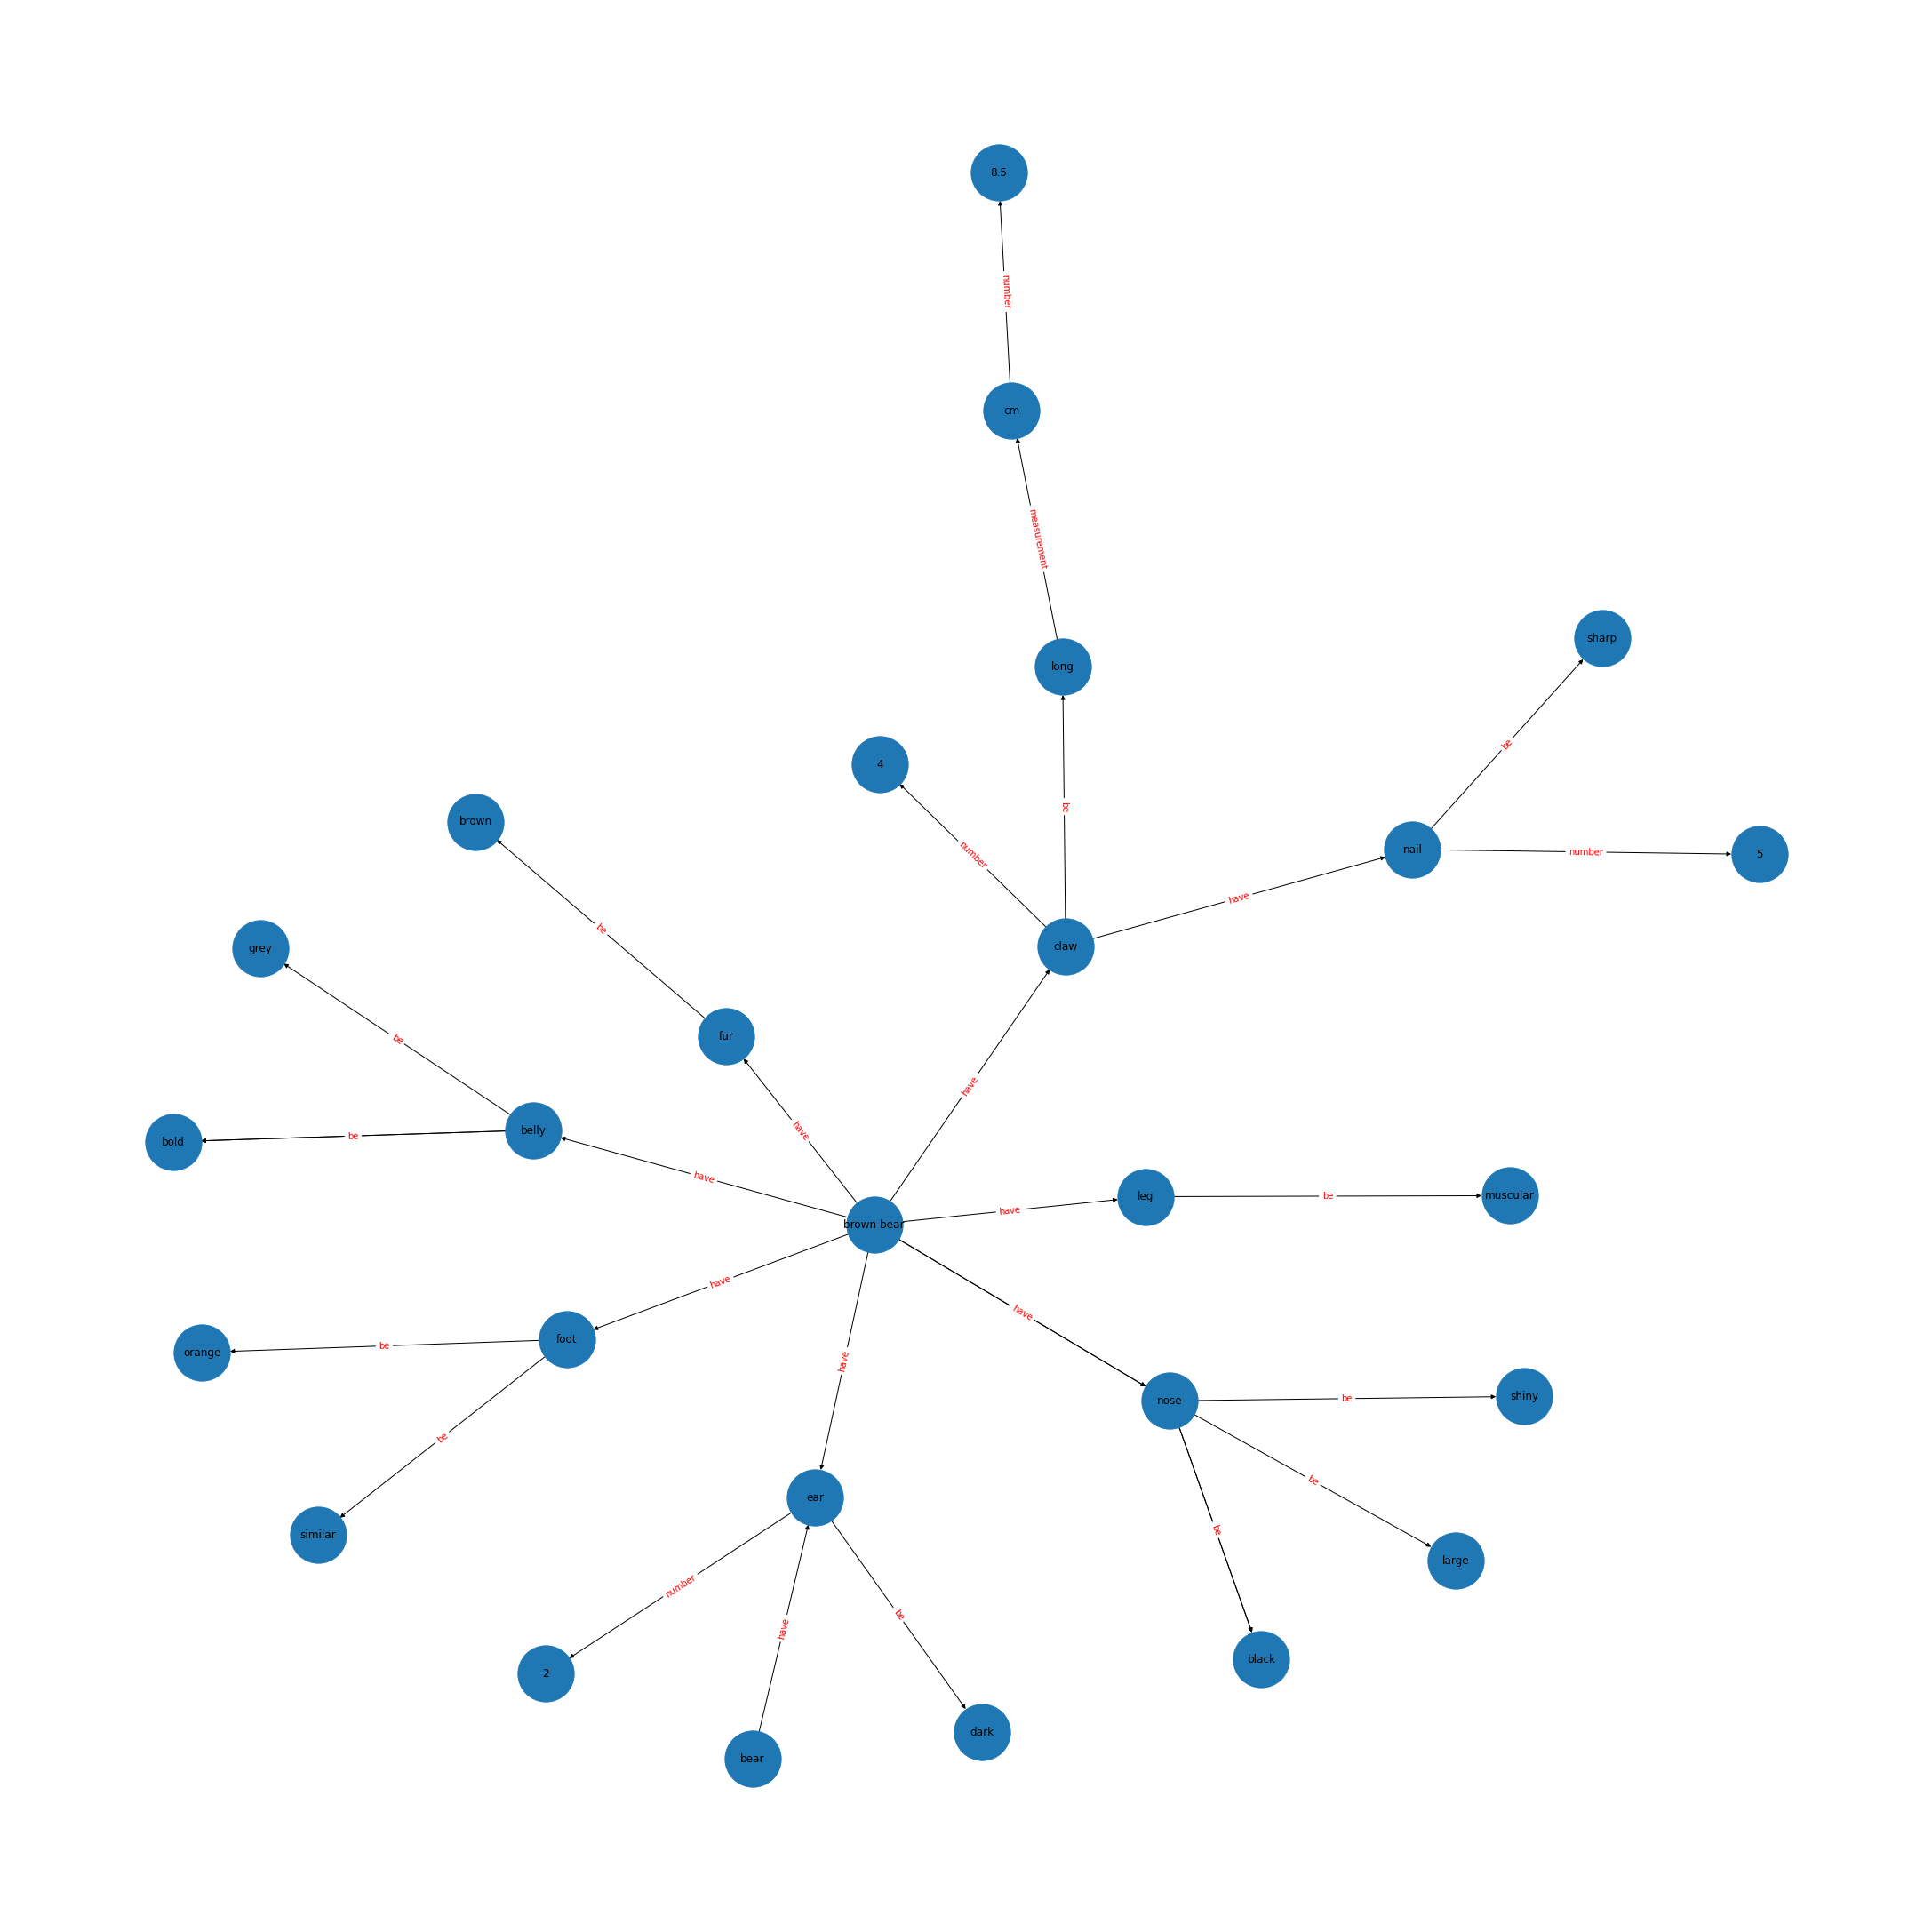

In [24]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(30, 30))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G, k = 1)
nx.draw(G, with_labels=True, node_size=4000, pos=graphviz_layout(G))
nx.draw_networkx_edge_labels(G, pos=graphviz_layout(G), edge_labels=labels,
                                 font_color='red')
plt.show()
#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')